In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})



model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128 
# learning rate is how fast it will descend
model_args['lr'] = .01
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .9
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 15
# logging frequency
model_args['log_interval'] = 100

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load the MINST dataset via torchvision 

divide data into training and validation subsets

In [2]:

transform = transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)

train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('../data', train=False, download=True, transform=transform)

In [3]:

loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

Printing basic info about data and visualization

50000
10000
10000
391
torch.Size([28, 28])


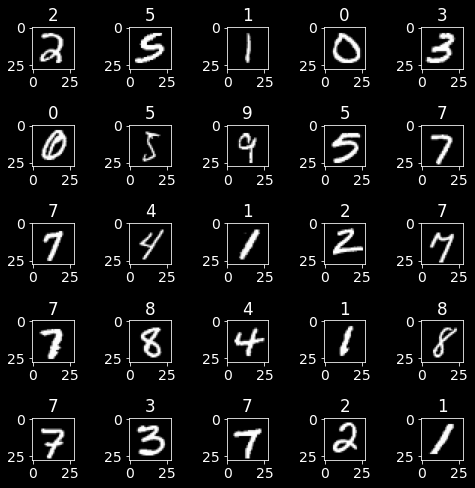

In [4]:
print(len(train_subset))
print(len(validation_subset))
print(len(test_subset)) 
print(len(train_loader)) 
example_number = 123
print(train_subset[example_number][0][0].shape) 

fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(train_subset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        axs[i,j].set_title(train_subset[example_number+i*5+j][1])

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout2d(p=0.25)
        self.drop2 = nn.Dropout2d(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)
        x = x.view(-1, 64 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [6]:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target, reduction='mean')
        loss.backward()
        optimizer.step()
        
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='mean') 
            prediction = output.argmax(dim=1)  
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss.cpu()

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.305788
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.523875
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.248550
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.155408

Train set: Average loss: 0.5260
Validation set: Average loss: 0.1061, Accuracy: 9658/10000 (97%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.181355
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.200953
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.057769
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.076199

Train set: Average loss: 0.1179
Validation set: Average loss: 0.0642, Accuracy: 9805/10000 (98%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.091828
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.121375
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.083955
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.047023

Train set: Average loss: 0.0887
Validation set: Average loss: 0.0552, Accuracy: 9825/10000 (98%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.034939
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.057264
Train Epoch: 4 [25600/5

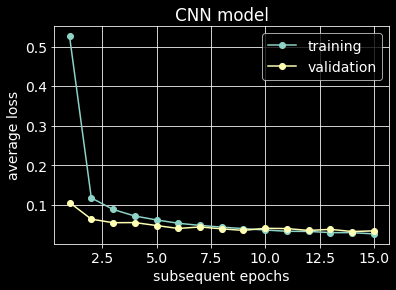

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN model')


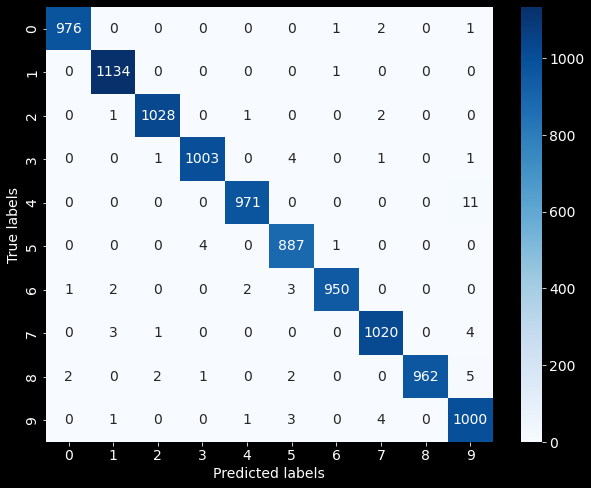

In [9]:
def plot_confusion_matrix(model, device, test_loader):
    model.eval()
    true_labels, predicted_labels = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            prediction = output.argmax(dim=1)
            true_labels.extend(target.cpu().numpy())
            predicted_labels.extend(prediction.cpu().numpy())
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

plot_confusion_matrix(model, device, test_loader)